In [ ]:
import uproot
import ROOT
import numpy as np

In [21]:
def pileup_reweight(hist_data, hist_mc, out_name, year):
    
    ''' 

    This function takes two root f/iles:

    hist_data: root file with data pileup histogram (not normalized)
    hist_mc: root file with mc pileup histogram (normalized)

    It will do:

    1. Normalize the data histogram with respect to the its total area.
    2. Compute weights between data and MC and return it.
    3. Plot the histograms before the weighting process.


    '''
    #ROOT.gROOT.SetBatch(ROOT.kFALSE)
    
    # open root file using TFile
    file_data = ROOT.TFile.Open(hist_data, "READ")
    file_mc = ROOT.TFile.Open(hist_mc, "READ")
    
    # Get the histograms
    hist_data = file_data.Get("pileup")
    hist_mc = file_mc.Get("input_Event/N_TrueInteractions")
    hist_mc.SetLineColor(ROOT.kRed)
    
    # Change in the x-axis
    hist_data.GetXaxis().SetRangeUser(0, 70)
    hist_data.GetXaxis().SetRangeUser(0, 70)
    
    # Verify the number of bins
    if hist_data.GetNbinsX() != hist_mc.GetNbinsX():
        if hist_data.GetNbinsX() > hist_mc.GetNbinsX():
            hist_data.Rebin(hist_data.GetNbinsX() // hist_mc.GetNbinsX())
        else:
            hist_mc.Rebin(hist_mc.GetNbinsX() // hist_data.GetNbinsX())
            
    print(hist_data.GetNcells())
    print(hist_mc.GetNcells())
    
    ## Normalize data histogram 
    
    # Takes the integral and normalize
    norm_factor = hist_data.Integral()
    scal = 1/norm_factor
    hist_data.Scale(scal)
    
    hist_data.SetMinimum(0)
    hist_data.SetMaximum(0.2)
    
    yd = hist_data.GetYaxis()
    yd.SetTitle('Entries')
    
    xd = hist_data.GetXaxis()
    xd.SetTitle('Num. of rec. vertices')
    
    ## Creates the ratio histogram
    
    # Clone it from data histogram
    hist_ratio = hist_data.Clone("weight_histogram")
    hist_ratio.SetLineColor(ROOT.kBlack)
    hist_ratio.SetMarkerStyle(21)
    hist_ratio.SetTitle("") # Label inside the plot
    hist_ratio.SetMinimum(0.0)
    hist_ratio.SetMaximum(0.2)
    hist_ratio.Sumw2()
    hist_ratio.SetStats(0) # To remove stats bar
    
    #print(hist_mc.GetNcells())
    #print(hist_ratio.GetNcells())
    
    # Takes the ratio between data and mc
    hist_ratio.Divide(hist_mc)
    
    ## Stores the values for bins and weigths
        
    # Take the number of bins
    nbins = hist_ratio.GetNcells()
    
    # array for storing bins and bins content
    bins = np.empty([nbins])
    mc_weight = np.empty([nbins])
    
    # loop to do the weighting
    for i in range(0, nbins):
        # Take the bin content (weight)
        weight = hist_ratio.GetBinContent(i)
        # Take the unweighted mc value
        '''mc_current_content = hist_mc.GetBinContent(i)
        # Compute the weighted mc value
        mc_weighted_content = mc_current_content * weight'''
        # Store the bins and the mc content weighted
        bins[i] = i
        #mc_weight[i] = mc_weighted_content
        mc_weight[i] = weight
    
    ## To plot the histograms
    
    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetOptStat(0)
    
    # Adjust y-axis settings
    y = hist_ratio.GetYaxis()
    y.SetTitle("Data/MC")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)

    # Adjust x-axis settings
    x = hist_ratio.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)
    
    c = ROOT.TCanvas("c", "canvas", 800, 800)
    # Upper histogram plot is pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.35, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.SetGridy()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.Draw()
    
    leg_bef = ROOT.TLegend(0.7,0.8,0.9, 0.9)
    leg_bef.SetHeader("Title","C");
    leg_bef.AddEntry(hist_data,"Data","f")
    leg_bef.AddEntry(hist_mc,"MC","f")
    leg_bef.Draw()
    
    # CMS Format
    right = ROOT.TLatex()
    right.SetNDC()
    right.SetTextFont(43)
    right.SetTextSize(40)
    right.SetTextAlign(13)
    right.DrawLatex(0.11, 0.979,"#bf{CMS} #scale[0.7]{#it{Preliminary}}")
    right.SetTextSize(34)
    right.SetTextSize(25)
    right.DrawLatex(.71,0.965 , year[:4] + ' (13 TeV)')
    
    # draw everything
    pad1.cd()
    hist_data.Draw()
    hist_mc.Draw("same")    
    pad2.cd()
    hist_ratio.SetMinimum(0.05)
    hist_ratio.SetMaximum(2.5)
    hist_ratio.Draw("ep")
    #hist_ratio.Draw()
    c.Draw()
        
    c.SaveAs("ratio_plot_before_" + year + ".png")
    #del(c)
    
    # To save the weighed histogram
    file_hist = ROOT.TFile(out_name, "RECREATE")
    
    hist_ratio.Write()
    file_hist.Write()
    file_hist.Close()
    
    return bins, mc_weight

In [22]:
def plot_mc_weight(hist_data, hist_mc, out_name, year):
    
    ''' 

    This function takes two root files:

    hist_data: root file with data pileup histogram (not normalized)
    hist_mc: root file with mc pileup histogram (normalized)

    It will do:

    1. Normalize the data histogram with respect to the its total area.
    2. Weight the mc histogram by using the previous function
    3. Plot the histograms after the weighting process.


    '''
    
    bins, weight = pileup_reweight(hist_data, hist_mc, out_name, year)
    
    # open root file using TFile
    file_data = ROOT.TFile.Open(hist_data, "READ")
    file_mc = ROOT.TFile.Open(hist_mc, "READ")
    # Get the histograms
    hist_data = file_data.Get("pileup")
    hist_mc = file_mc.Get("input_Event/N_TrueInteractions")
    hist_mc.SetLineColor(ROOT.kRed)
    
    # Change in the x-axis
    hist_data.GetXaxis().SetRangeUser(0, 70)
    hist_data.GetXaxis().SetRangeUser(0, 70)
    
    # Verify the number of bins
    if hist_data.GetNbinsX() != hist_mc.GetNbinsX():
        if hist_data.GetNbinsX() > hist_mc.GetNbinsX():
            hist_data.Rebin(hist_data.GetNbinsX() // hist_mc.GetNbinsX())
        else:
            hist_mc.Rebin(hist_mc.GetNbinsX() // hist_data.GetNbinsX())
    
    ## Normalize data histogram 
    
    # Takes the integral and normalize
    norm_factor = hist_data.Integral()
    scal = 1/norm_factor
    hist_data.Scale(scal)
    
    hist_data.SetMinimum(0)
    hist_data.SetMaximum(0.2)
    
    yd = hist_data.GetYaxis()
    yd.SetTitle('Entries')
    
    xd = hist_data.GetXaxis()
    xd.SetTitle('Num. of rec. vertices')
    
    ## Creates the ratio histogram
    
    # Clone it from data histogram
    hist_ratio = hist_data.Clone("weight_histogram")
    hist_ratio.SetLineColor(ROOT.kBlack)
    hist_ratio.SetMarkerStyle(21)
    hist_ratio.SetTitle("") # Label inside the plot
    hist_ratio.SetMinimum(0.0)
    hist_ratio.SetMaximum(0.2)
    hist_ratio.Sumw2()
    hist_ratio.SetStats(0) # To remove stats bar
    
    # Takes the ratio between data and mc
    #hist_ratio.Divide(hist_mc)
    
    ## Stores the values for bins and weigths
        
    # Take the number of bins
    nbins = hist_ratio.GetNcells()
    
    # array for storing bins and bins content
    #bins = np.empty([nbins])
    #mc_weight = np.empty([nbins])
    
    # loop to do the weighting
    for i in range(0, nbins):
        hist_mc.SetBinContent(i, weight[i]*hist_mc[i]) 
        #hist_mc.SetBinContent(i, weight[i]) 
    
    #print(hist_mc.GetNcells())
    #print(hist_ratio.GetNcells())
    hist_ratio.Divide(hist_mc)
    
    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetOptStat(0)
    
    # Adjust y-axis settings
    y = hist_ratio.GetYaxis()
    y.SetTitle("Data/MC")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)

    # Adjust x-axis settings
    x = hist_ratio.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)
    
    c = ROOT.TCanvas("c", "canvas", 800, 800)
    # Upper histogram plot is pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.35, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.SetGridy()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.Draw()
    
    leg_bef = ROOT.TLegend(0.7,0.8,0.9, 0.9)
    leg_bef.SetHeader("Title","C");
    leg_bef.AddEntry(hist_data,"Data","f")
    leg_bef.AddEntry(hist_mc,"MC","f")
    leg_bef.Draw()
    
    # CMS Format
    right = ROOT.TLatex()
    right.SetNDC()
    right.SetTextFont(43)
    right.SetTextSize(40)
    right.SetTextAlign(13)
    right.DrawLatex(0.11, 0.979,"#bf{CMS} #scale[0.7]{#it{Preliminary}}")
    right.SetTextSize(34)
    right.SetTextSize(25)
    right.DrawLatex(.71,0.965 , year[:4] +  ' (13 TeV)')
    
    # draw everything
    pad1.cd()
    hist_data.Draw()
    hist_mc.Draw("same")    
    pad2.cd()
    hist_ratio.SetMinimum(0.5)
    hist_ratio.SetMaximum(1.5)
    hist_ratio.Draw("ep")
    #hist_ratio.Draw()
    c.Draw()
    c.SaveAs("ratio_plot_after_" + year + " .png")

In [23]:
import ipywidgets as widgets
from IPython.display import display

# Dropdown widget with options
options = widgets.Dropdown(
    options=['2016-pre-VFP', '2016-pos-VFP', '2017', '2018'],
    value='2016-pre-VFP',
    description='Monte Carlo:',
)

# Button widget
button = widgets.Button(
    description='Run',
    button_style='success'
)

# Output widget
output = widgets.Output()

# Function to display the selected option
def on_button_click(b):
    with output:
        output.clear_output()
        print(f"Selected option: {options.value}")
        
        if options.value == '2016-pre-VFP':
                 
            # Name of data histograms
            hist_data = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2016-preVFP-69200ub-99bins.root"
            # Name of MC histograms
            hist_mc = "/afs/cern.ch/user/e/ealvesco/public/ToMapse/PileupMC_2016_pre.root"
            # Name of the output file with the weight
            out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2016-pre-VFP.root"
            # Call the function to produce plots before weighting, after weighting, and root file with weights
            plot_mc_weight(hist_data, hist_mc, out_name, '2016-pre-VFP')
        
        elif options.value == '2016-pos-VFP':
            
            # Name of data histograms
            hist_data = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2016-postVFP-69200ub-99bins.root"
            # Name of MC histograms
            hist_mc = "/afs/cern.ch/user/e/ealvesco/public/ToMapse/PileupMC_2016_post.root"
            # Name of the output file with the weight
            out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2016-post-VFP.root"
            # Call the function to produce plots before weighting, after weighting, and root file with weights
            plot_mc_weight(hist_data, hist_mc, out_name, '2016-pos-VFP')
            
        elif options.value == '2017':
            
            # Name of data histograms
            hist_data = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions17/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2017-69200ub-99bins.root"
            # Name of MC histograms
            hist_mc = "/afs/cern.ch/user/e/ealvesco/public/ToMapse/PileupMC_2017.root"
            # Name of the output file with the weight
            out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2017.root"
            # Call the function to produce plots before weighting, after weighting, and root file with weights
            plot_mc_weight(hist_data, hist_mc, out_name, '2017')
            
        elif options.value == '2018':
            
            # Name of data histograms
            hist_data = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions18/13TeV/PileUp/UltraLegacy/PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root"
            # Name of MC histograms
            hist_mc = "/afs/cern.ch/user/e/ealvesco/public/ToMapse/PileupMC_2017.root"
            # Name of the output file with the weight
            out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2018.root"
            # Call the function to produce plots before weighting, after weighting, and root file with weights
            plot_mc_weight(hist_data, hist_mc, out_name, '2018')
            
            
# Link the button click event to the function
button.on_click(on_button_click)

# Display the widgets
display(options, button, output)

Dropdown(description='Monte Carlo:', options=('2016-pre-VFP', '2016-pos-VFP', '2017', '2018'), value='2016-pre…

Button(button_style='success', description='Run', style=ButtonStyle())

Output()

101
101


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_before.png has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_after.png has been created


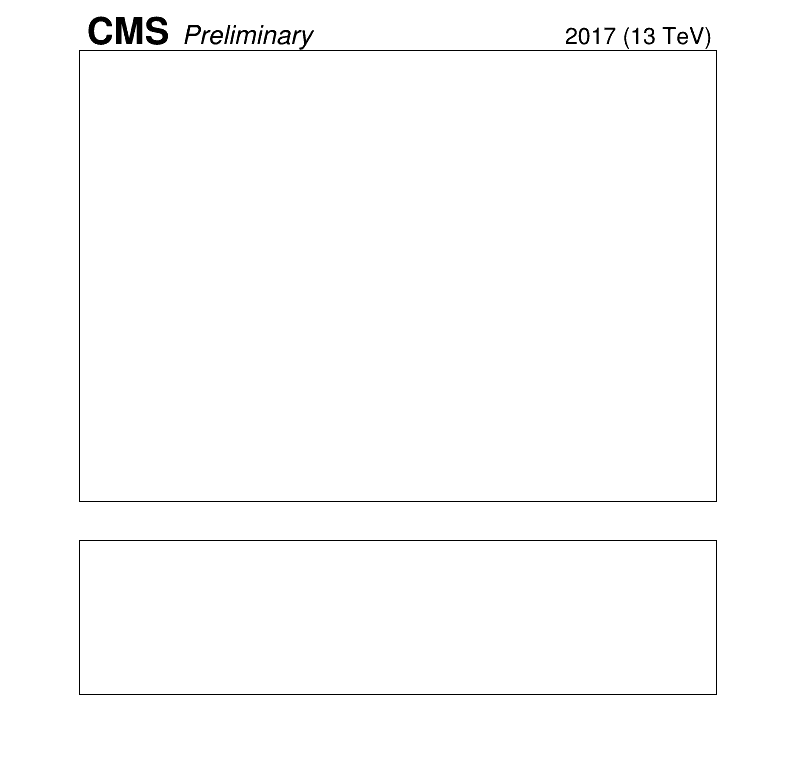

In [63]:
# Path for data histograms
#path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/UltraLegacy/'
path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions17/13TeV/PileUp/UltraLegacy/'
#path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions18/13TeV/PileUp/UltraLegacy/'
# Name of data histograms
#hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2016-preVFP-66000ub-99bins.root"
#hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2016-postVFP-66000ub-99bins.root"
hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2017-66000ub-99bins.root"
#hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2018-66000ub-99bins.root"
# Name of MC histograms
#hist_mc = "PileupMC_2016.root"
#hist_mc = "PileupMC_2017.root"
hist_mc = "/afs/cern.ch/user/e/ealvesco/public/ToMapse/PileupMC_2017.root"
#hist_mc = "PileupMC_2018.root"
# Year
#year = '2016'
year = '2017'
#year = '2018'
# Name of the output file with the weight
out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2017.root"

# Call the function to produce plots before weighting, after weighting, and root file with weights
plot_mc_weight(hist_data, hist_mc, out_name, year)

# For tests!

[0.         4.7595777  1.08063694 1.2167456  0.88091777 0.76623882
 1.0115455  1.32314403 1.33956045 1.10452557 0.91235546 0.82408344
 0.8003965  0.79077531 0.80678132 0.83239373 0.85640635 0.87251026
 0.88210141 0.89466452 0.91871003 0.94641737 0.96640749 0.98016381
 0.9908424  0.99259966 0.98739473 0.97978292 0.98128912 0.98688717
 0.99286315 0.99822761 1.00175759 1.00338579 1.0051285  1.0066244
 1.00883798 1.01166003 1.01603152 1.02087936 1.02818742 1.03717997
 1.04711105 1.05848278 1.07108808 1.08183655 1.09509997 1.10982116
 1.12598728 1.14247506 1.15474812 1.16807478 1.17696172 1.1830876
 1.19963882 1.19722499 1.19508129 1.19157702 1.20947465 1.21860511
 1.23955885 1.25289198 1.23923531 1.17116505 1.0816796  1.00671165
 0.91249765 0.86009568 0.78209926 0.65758466 0.63088225 0.59884724
 0.71411298 0.71516762 0.53603481 0.40905133 0.42830628 0.44173172
 0.4423567  1.03534653 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file ratio_plot_before.png has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_after.png has been created


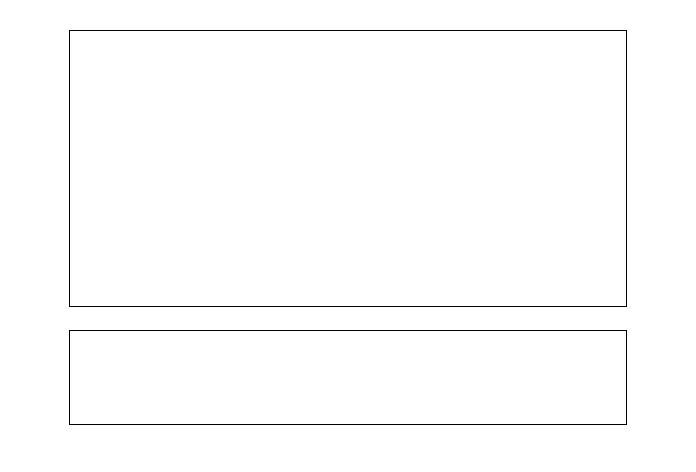

In [8]:
def pileup_reweight(hist_data, hist_mc):

    # open root file using TFile
    file_data = ROOT.TFile.Open(hist_data, "READ")
    file_mc = ROOT.TFile.Open(hist_mc, "READ")
    # Get the histograms
    hist_data = file_data.Get("pileup")
    hist_mc = file_mc.Get("input_Event/N_TrueInteractions")

    ## Normalize data histogram 

    # Takes the integral and normalize
    norm_factor = hist_data.Integral()
    scal = 1/norm_factor
    hist_data.Scale(scal)

    hist_data.SetMinimum(0)
    hist_data.SetMaximum(0.1)

    yd = hist_data.GetYaxis()
    yd.SetTitle('Entries')

    xd = hist_data.GetXaxis()
    xd.SetTitle('Num. of rec. vertices')

    ## Creates the ratio histogram

    # Clone it from data histogram
    hist_ratio = hist_data.Clone("Auxiliar")
    hist_ratio.SetLineColor(ROOT.kBlack)
    hist_ratio.SetMarkerStyle(21)
    hist_ratio.SetTitle("") # Label inside the plot
    hist_ratio.SetMinimum(0.0)
    hist_ratio.SetMaximum(0.2)
    # Set up plot for markers and errors
    hist_ratio.Sumw2()
    hist_ratio.SetStats(0) # To remove stats bar

    # Takes the ratio between data and mc
    hist_ratio.Divide(hist_mc)

    ## Stores the values for bins and weigths

    # Take the number of bins
    nbins = hist_ratio.GetNcells()

    # array for storing bins and bins content
    bins = np.empty([nbins])
    mc_weight = np.empty([nbins])

    # loop to do the weighting
    for i in range(0, nbins):
        weight = hist_ratio.GetBinContent(i)
        '''mc_current_content = hist_mc.GetBinContent(i)
        mc_weighted_content = mc_current_content * weight'''

        bins[i] = i
        mc_weight[i] = weight

    print(mc_weight)
    # Adjust y-axis settings
    y = hist_ratio.GetYaxis()
    y.SetTitle("Ratio Plot")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)

    # Adjust x-axis settings
    x = hist_ratio.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)

    c = ROOT.TCanvas("c", "canvas")
    # Upper histogram plot is pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.35, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.SetGridy()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.Draw()

    # draw everything
    pad1.cd()
    hist_data.Draw()
    hist_mc.Draw("same")    
    pad2.cd()
    hist_ratio.Draw("ep")
    c.Draw()
    c.SaveAs("ratio_plot_before.png")

    return bins, mc_weight


def plot_mc_weight(hist_data, hist_mc):


    bins, weight = pileup_reweight(hist_data, hist_mc)

    # open root file using TFile
    file_data = ROOT.TFile.Open(hist_data, "READ")
    file_mc = ROOT.TFile.Open(hist_mc, "READ")
    # Get the histograms
    hist_data = file_data.Get("pileup")
    hist_mc = file_mc.Get("input_Event/N_TrueInteractions")

    ## Normalize data histogram 

    # Takes the integral and normalize
    norm_factor = hist_data.Integral()
    scal = 1/norm_factor
    hist_data.Scale(scal)

    hist_data.SetMinimum(0)
    hist_data.SetMaximum(0.06)

    yd = hist_data.GetYaxis()
    yd.SetTitle('Entries')

    xd = hist_data.GetXaxis()
    xd.SetTitle('Num. of rec. vertices')

    ## Creates the ratio histogram

    # Clone it from data histogram
    hist_ratio = hist_data.Clone("Auxiliar")
    hist_ratio.SetLineColor(ROOT.kBlack)
    hist_ratio.SetMarkerStyle(21)
    hist_ratio.SetTitle("") # Label inside the plot
    hist_ratio.SetMinimum(0.0)
    hist_ratio.SetMaximum(0.2)
    # Set up plot for markers and errors
    hist_ratio.Sumw2()
    hist_ratio.SetStats(0) # To remove stats bar

    # Takes the ratio between data and mc
    #hist_ratio.Divide(hist_mc)

    ## Stores the values for bins and weigths

    # Take the number of bins
    nbins = hist_ratio.GetNcells()

    # array for storing bins and bins content
    #bins = np.empty([nbins])
    #mc_weight = np.empty([nbins])

    # loop to do the weighting
    for i in range(0, nbins):
        hist_mc.SetBinContent(i, weight[i]) 

    hist_ratio.Divide(hist_mc)


    # Adjust y-axis settings
    y = hist_ratio.GetYaxis()
    y.SetTitle("Ratio Plot")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)

    # Adjust x-axis settings
    x = hist_ratio.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)



    c = ROOT.TCanvas("c", "canvas")
    # Upper histogram plot is pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.35, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.SetGridy()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.Draw()

    # draw everything
    pad1.cd()
    hist_data.Draw()
    hist_mc.Draw("same")    
    pad2.cd()
    hist_ratio.Draw("ep")
    c.Draw()
    c.SaveAs("ratio_plot_after.png")


if __name__ == '__main__':

    #hist_data = "/eos/user/e/ealvesco/DPSAnalysis/JPsitoDstar/PileupHistogram-goldenJSON-13tev-2016-69200ub-99bins.root"
    #hist_mc = "/eos/user/e/ealvesco/DPSAnalysis/JPsitoDstar/PileupMC_2016.root"
    
    #path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/UltraLegacy/'
    #path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions17/13TeV/PileUp/UltraLegacy/'
    path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions18/13TeV/PileUp/UltraLegacy/'
    hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root"
    hist_mc = "PileupMC_2018.root"


    plot_mc_weight(hist_data, hist_mc)

In [9]:
path_data = '/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/UltraLegacy/'
hist_data = path_data + "PileupHistogram-goldenJSON-13tev-2016-preVFP-66000ub-99bins.root"
hist_mc = "PileupMC_2016.root"
year = '2016'
out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2016.root"
plot_mc_weight(hist_data, hist_mc, out_name, year)

TypeError: plot_mc_weight() takes 2 positional arguments but 4 were given

In [7]:
hist_data = "PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root"
hist_mc = "PileupMC_2018.root"
out_name = "/afs/cern.ch/work/m/mabarros/public/CMSSW_10_6_12/src/analysis_monte_carlo/efficiencies_new/OniaOpenCharmRun2ULAna/data/corrections/pile_up_reweight_2016.root"
#a, weight = plot_mc_weight(hist_data, hist_mc, out_name)

101
101


TypeError: cannot unpack non-iterable NoneType object

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_before.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_after.png has been created


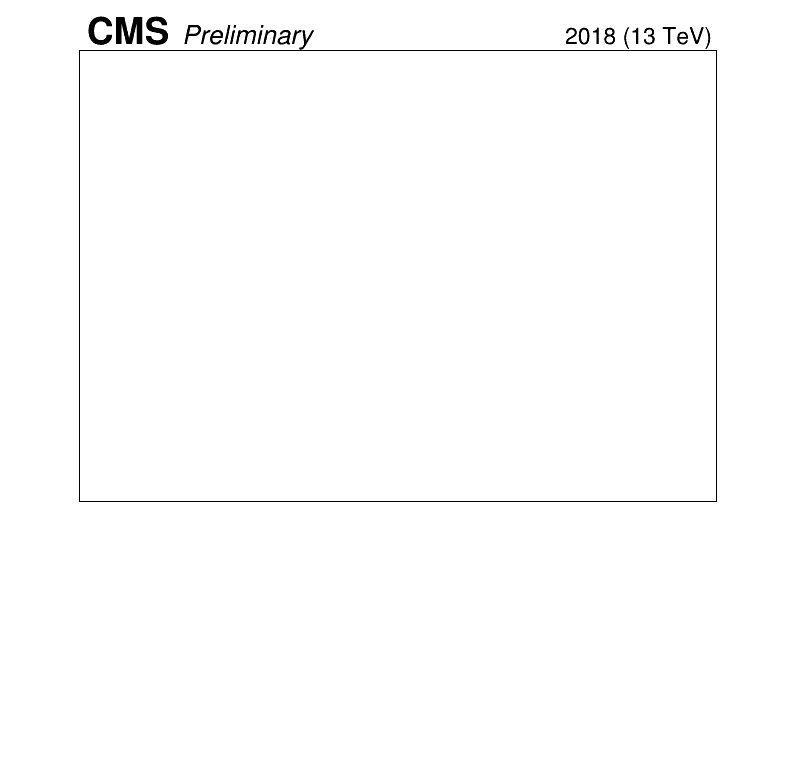

In [9]:
file_data = ROOT.TFile.Open("PileupHistogram-goldenJSON-13tev-2018-69200ub-99bins.root", "READ")
file_mc = ROOT.TFile.Open( "/afs/cern.ch/work/m/mabarros/public/MonteCarlo/Pileup/CMSSW_10_6_28/src/UHH2/scripts/PileupMC_2018.root", "READ")
# Get the histograms
hist_data = file_data.Get("pileup")
hist_mc = file_mc.Get("input_Event/N_TrueInteractions")

OSError: Failed to open file /afs/cern.ch/work/m/mabarros/public/MonteCarlo/Pileup/CMSSW_10_6_28/src/UHH2/scripts/PileupMC_2018.root

Error in <TFile::TFile>: file /afs/cern.ch/work/m/mabarros/public/MonteCarlo/Pileup/CMSSW_10_6_28/src/UHH2/scripts/PileupMC_2018.root does not exist


In [7]:
# Get bins and values
bins, weight = pileup_reweight(hist_data, hist_mc, 'x.root')

In [8]:
weight

array([0.00000000e+00, 2.60180761e-01, 3.66280427e-01, 8.86416985e-01,
       8.53913698e-01, 9.36388025e-01, 7.92120884e-01, 7.88952855e-01,
       7.47780021e-01, 7.03492281e-01, 6.90621392e-01, 7.22293521e-01,
       7.63616576e-01, 8.02461073e-01, 8.33534448e-01, 8.60262304e-01,
       8.91472581e-01, 9.21167027e-01, 9.47354368e-01, 9.66502829e-01,
       9.78866323e-01, 9.87833810e-01, 9.98717319e-01, 1.01351191e+00,
       1.02940805e+00, 1.04162965e+00, 1.05149287e+00, 1.05886233e+00,
       1.06605575e+00, 1.07539277e+00, 1.08729080e+00, 1.09980297e+00,
       1.11501640e+00, 1.13631813e+00, 1.16288173e+00, 1.19093550e+00,
       1.21742166e+00, 1.24731720e+00, 1.27436311e+00, 1.30336075e+00,
       1.32982530e+00, 1.35124281e+00, 1.37268062e+00, 1.40039759e+00,
       1.43520027e+00, 1.48162260e+00, 1.49863022e+00, 1.51638238e+00,
       1.53271001e+00, 1.48396979e+00, 1.38515621e+00, 1.23230563e+00,
       1.07827692e+00, 8.77265578e-01, 7.28622270e-01, 5.79999685e-01,
      

In [ ]:
################################# TEST!!!!!!!!!!!!!!!!!!!!!!!! ####################################

In [35]:
def comp_mc(hist_mc_mine, hist_mc_pog):
    
    # open root file using TFile
    file_mc_mine = ROOT.TFile.Open(hist_mc_mine, "READ")
    file_mc_pog = ROOT.TFile.Open(hist_mc_pog, "READ")
    # Get the histograms
    hist_mc_mine = file_mc_mine.Get("input_Event/N_TrueInteractions")
    hist_mc_pog = file_mc_pog.Get("pileup")
    
    yd = hist_mc_mine.GetYaxis()
    yd.SetTitle('Entries')
    
    xd = hist_mc_mine.GetXaxis()
    xd.SetTitle('Num. of rec. vertices')
    
    # Takes the integral and normalize
    norm_factor = hist_mc_pog.Integral()
    scal = 1/norm_factor
    hist_mc_pog.Scale(scal)
    
    ## Creates the ratio histogram
    
    # Clone it from data histogram
    hist_ratio = hist_mc_mine.Clone("Auxiliar")
    hist_ratio.SetLineColor(ROOT.kBlack)
    hist_ratio.SetMarkerStyle(21)
    hist_ratio.SetTitle("") # Label inside the plot
    hist_ratio.SetMinimum(0.0)
    hist_ratio.SetMaximum(0.2)
    hist_ratio.SetStats(0) # To remove stats bar
    
    # Takes the ratio between data and mc
    hist_ratio.Divide(hist_mc_pog)
    
    ## Stores the values for bins and weigths
        
    # Take the number of bins
    nbins = hist_ratio.GetNcells()
    
    # array for storing bins and bins content
    bins = np.empty([nbins])
    mc_weight = np.empty([nbins])
    
    # loop to do the weighting
    for i in range(0, nbins):
        # Take the bin content (weight)
        weight = hist_ratio.GetBinContent(i)
        # Take the unweighted mc value
        mc_current_content = hist_mc_pog.GetBinContent(i)
        # Compute the weighted mc value
        mc_weighted_content = mc_current_content * weight
        # Store the bins and the mc content weighted
        bins[i] = i
        mc_weight[i] = mc_weighted_content
    
    ## To plot the histograms
    
    # Adjust y-axis settings
    y = hist_ratio.GetYaxis()
    y.SetTitle("Ratio Plot")
    y.SetNdivisions(505)
    y.SetTitleSize(20)
    y.SetTitleFont(43)
    y.SetTitleOffset(1.55)
    y.SetLabelFont(43)
    y.SetLabelSize(15)

    # Adjust x-axis settings
    x = hist_ratio.GetXaxis()
    x.SetTitleSize(20)
    x.SetTitleFont(43)
    x.SetTitleOffset(4.0)
    x.SetLabelFont(43)
    x.SetLabelSize(15)
    
    c = ROOT.TCanvas("c", "canvas", 800, 800)
    # Upper histogram plot is pad1
    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.35, 1, 1.0)
    pad1.SetBottomMargin(0)  # joins upper and lower plot
    pad1.SetGridx()
    pad1.SetGridy()
    pad1.Draw()
    # Lower ratio plot is pad2
    c.cd()  # returns to main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)  # joins upper and lower plot
    pad2.SetBottomMargin(0.2)
    pad2.SetGridx()
    pad2.SetGridy()
    pad2.Draw()
    
    # draw everything
    pad1.cd()
    #hist_mc_mine.Draw()
    hist_mc_pog.Draw()    
    pad2.cd()
    hist_ratio.Draw("ep")
    c.Draw()
    c.SaveAs("test.png")
    del(c)
    

In [16]:
hist_mc_mine = "PileupMC.root"
hist_mc_pog = "pileup_2017_shifts.root"
comp_mc(hist_mc_mine, hist_mc_pog)

NameError: name 'comp_mc' is not defined

In [27]:
hist_data = "PileupData.root"
hist_mc = "PileupMC.root"
# open root file using TFile
file_data = ROOT.TFile.Open(hist_data, "READ")
file_mc = ROOT.TFile.Open(hist_mc, "READ")
# Get the histograms
hist_data = file_data.Get("pileup")
hist_mc = file_mc.Get("input_Event/N_TrueInteractions")
norm_factor = hist_data.Integral()
scal = 1/norm_factor
hist_data.Scale(scal)

hist_data.SetMinimum(0)
hist_data.SetMaximum(0.06)

hist_ratio = ROOT.TH1D('r', 'r', 100, 0, 100)


In [28]:
nbins = hist_data.GetNcells()
for i in range(nbins):
    data = hist_data.GetBinContent(i)
    mc = hist_mc.GetBinContent(i)
    if mc == 0:
        continue
    hist_ratio.SetBinContent(i, data/mc)

file_hist = ROOT.TFile("pileup_weight.root", "RECREATE")

hist_ratio.Write()
file_hist.Write()
file_hist.Close()

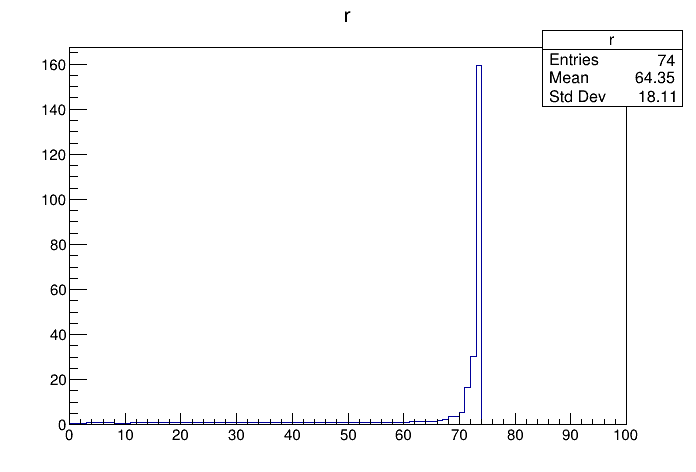

In [29]:
canvas = ROOT.TCanvas()
hist_ratio.Draw()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_plot_before.png has been created


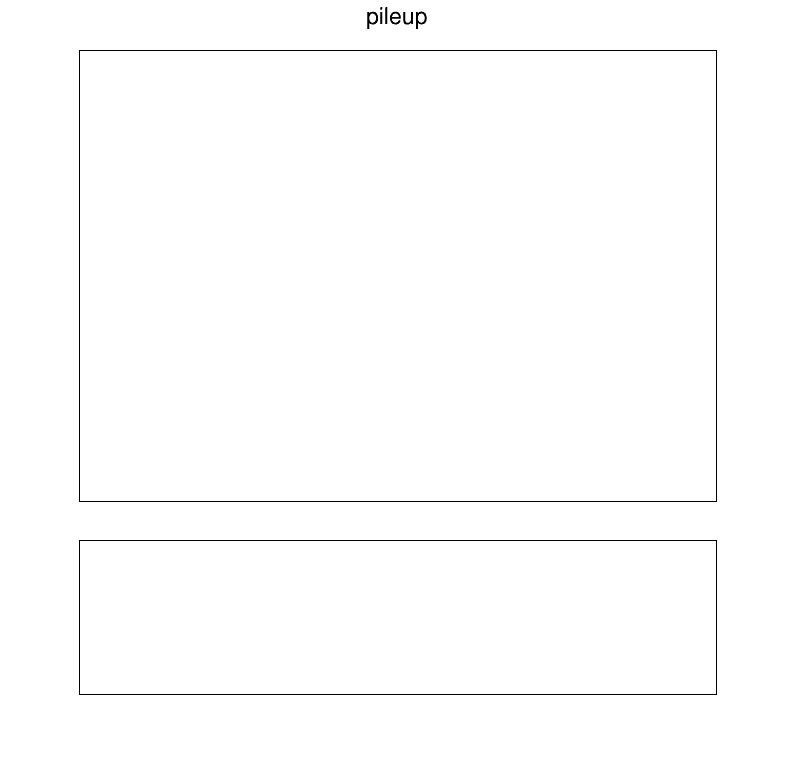

In [18]:
hist_data = "PileupData.root"
hist_mc = "PileupMC.root"
bins, weight = pileup_reweight(hist_data, hist_mc)

In [11]:
bins, weight

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100.]),
 array([  0.        ,   0.56062745,   0.73567685,   0.53791886,
          1.21823406,   0.80225897,   0.91629766,   1.00353531,
          0.925153  ,   0.68467588,   0.71316433,   0.75051215,
          0.81651768,   0.83766911,   0.84635563,   0.84402833,
          0.84390675,   0.86662881,   0.89296166,   0.91